### Strand Classifier Using one Minhash Function
* A single threaded implementation of Strand as a SciKit Estimator using **only one** hashing functions. 

**This notebook shows performance differences using:**
* A single minhash function.
* Stratified Cross Validation using only one fold with an 80 / 20 split.
* 10-fold Stratified Cross Validation using 90 / 10 splits.
* Total Classes: 5
* Longest sequence in file: 3,188,780
* File Sequence Count: 541
* Input file size of 396,153 KB

**Observations:**
* 1-fold stratified cv @ 80 / 20 splits and (kmer_length=31, minhash_length=100) = 28.6 sec, 46.8% Accuracy
* 1-fold stratified cv @ 80 / 20 splits and (kmer_length=31, minhash_length=200) = 28.9 sec, 52.3% Accuracy 
* 1-fold stratified cv @ 80 / 20 splits and (kmer_length=31, minhash_length=300) = 28.5 sec, 53.2% Accuracy 
* 1-fold stratified cv @ 80 / 20 splits and (kmer_length=31, minhash_length=400) = 28.5 sec, 59.5% Accuracy 
* 1-fold stratified cv @ 80 / 20 splits and (kmer_length=31, minhash_length=500) = 28.2 sec, 60.4% Accuracy 
* 1-fold stratified cv @ 80 / 20 splits and (kmer_length=31, minhash_length=1000) = 28.3 sec, 71.2% Accuracy 
* 1-fold stratified cv @ 80 / 20 splits and (kmer_length=31, minhash_length=2000) = 29.3 sec, 78.4% Accuracy 
* 1-fold stratified cv @ 80 / 20 splits and (kmer_length=31, minhash_length=4000) = 22.3 sec, 78.4% Accuracy 
* 1-fold stratified cv @ 80 / 20 splits and (kmer_length=60, minhash_length=100) = 29.2 sec, 39.6% Accuracy 
* 10-fold stratified cv @ 90 / 10 splits and (kmer_length=31, minhash_length=2000) = 1min 36s, 85.2% Accuracy 

In [3]:
import numpy as np
from sys import maxsize
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels

In [4]:
# Created by Jake Drew on 03/16/2020
# All rights reserved - 03/2020
class StrandClassifierV2(BaseEstimator, ClassifierMixin):
    """
    Parameters
    ----------
    X_ : ndarray, shape (n_samples, n_features)
         The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
         The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
              The classes seen at :meth:`fit`.
    kmer_length : integer, breaking the gene sequence into chunks of this length  
    minhash_length: integer, the number of minhash values to be included in the minhash signature. 
                    Longer minhash signatures approximate Jaccard Similarity more accurately and take 
                    more time to create. The total number of randomly seeded hashing functions is 
                    also controlled by the value in minhash_length.
    minhash_store_ : dict() array, shape (minhash_length), key == minhash int, value = category array int
                      Partitions unique minhash values and category associations by hash function.
    """
    def __init__(self, kmer_length=20, minhash_length=100, random_state=None):
        self.kmer_length = kmer_length
        self.random_state = random_state
        self.minhash_length = minhash_length
        
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        Returns
        -------
        self : object
            Returns self.
        """
        self.random_state_ = check_random_state(self.random_state)
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, ensure_2d=False, dtype=None)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        # Store the training data (X) and targets (y) used to fit the model
        self.X_ = X
        self.y_ = y
        
        # Store the minhash values and respective categories
        self.minhash_store_ = dict()
        
        # Train the model for X and y
        for sequence, category in zip(X, y):   
            # Create minhash signatures for each sequence
            signature = self.create_minhash_signature(sequence)
            # Store minhash values and respective categories to minhash_store_ partitioned by hash function 
            self.add_signature_to_minhash_store(category, signature)
            
        # Return the classifier
        return self

    def predict(self, X):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X, ensure_2d=False, dtype=None)
        
        yhats = []
        for sequence in X:
            # Create a minhash signature from the sequence X
            signature = self.create_minhash_signature(sequence)
            # Score all categories using the minhash signature  
            category_stores = self.get_category_scores(signature)
            #Get the first category with the highest score
            winning_category = max(category_stores, key=category_stores.get)
            #Add to our predictions
            yhats.append(winning_category)
        
        return yhats
    
    def kmer_generator(self, sequence='', kmer_length=0):
        kmer_count = len(sequence) - (kmer_length - 1)
        for i in range(0, kmer_count):
            yield sequence[i:i + kmer_length]
    
    def create_minhash_signature(self, sequence):
        """
        Parameters
        ----------
        sequence : string, A gene sequence or other string data to be broken into kmers.
        ----------
        signature : array of int, shape (minhash_length), minimum hash value produced by each hash function
                    after hashing all kmers generated from sequence.
        """
        #Break sequence into hashed kmers, then sort
        kmer_hashes = [hash(kmer) for kmer in self.kmer_generator(sequence,self.kmer_length)]
        kmer_hashes.sort()
        #Take the first minhash_length hashes to create the signature 
        signature = kmer_hashes[:self.minhash_length]
        return signature
    
    def add_signature_to_minhash_store(self, category, minhash_signature):
        '''
        Parameters
        ----------
        category : int or string, the category value associated with this minhash_signature
        minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence. 
        '''
        # Add each minhash value and category to the minhash store
        for minhash_value in minhash_signature:
            # Do we already have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories == None:
                # No, so create a new category set for this minhash value
                self.minhash_store_[minhash_value] = {category}
            else: 
                #Yes, add the category to the minhash value's category set
                minhash_categories.add(category)
        return 
    
    '''
    Parameters
    ----------
    minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence.
    Returns
    ----------
    class_scores : dict, shape (minhash_length), key = category, value = category score int
                   The count of categories associated with each hash function's minhash value. 
    '''
    def get_category_scores(self, minhash_signature):
        # Create a dictionary of category / class scores
        class_scores = dict.fromkeys(self.classes_ , 0)
        # lookup minhash values in minhash stores 
        for minhash_value in minhash_signature:
            # Do we have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories != None:
                # Yes, add 1 for each category in the set  
                for category in minhash_categories:
                    class_scores[category] += 1
        return class_scores
    

## Cross Validation

In [1]:
def read_fasta_file(file_path):
    X = []
    y = []
    with open(file_path, 'r') as dat:
        for line in dat.readlines():
            #print(line)
            if line[0] == '>':
                g_start = line.find("g__")
                g_end = line.find(";", g_start)
                genus = line[g_start:g_end]
                y.append(genus)
            else:
                X.append(line)
    return X, y

In [2]:
import pandas as pd

# Read in the fasta file
X, y = read_fasta_file('D:/Strand/Journal/NCBI_HiSeq_Strand/HiSeqTrainData.Strand')
#Remove low count genera that halt cross validation
data = {'X': X,'y':y}
df = pd.DataFrame(data)

In [3]:
#Inspect counts for each class
vcts = df.y.value_counts()
low_vcts = vcts[vcts < 15].index.values

In [4]:
#Remove low count genera. Any classes < the fold count will halt cross validation
df = df[~df.y.isin(low_vcts)]
df.y.value_counts()

g__streptococcus    221
g__xanthomonas      151
g__pelosinus        134
g__rhodobacter       18
g__vibrio            17
Name: y, dtype: int64

In [5]:
X = df.X.values
y = df.y.values

In [6]:
print('File Size: ' + str(len(X)))

File Size: 541


In [7]:
print('Longest Sequence Chars:' + str(len(max(X, key=len))))

Longest Sequence Chars:3188780


In [11]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, accuracy_score

def per_class_accuracy(ytrue,yhat):
    conf = confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title='',class_list=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel(class_list)
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100* accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()

## Test at kmer_length=31, minhash_length=100,

In [16]:
%%time
from sklearn.model_selection import StratifiedKFold

# create cross validation iterator
cv = StratifiedKFold(n_splits=5, random_state=42)

#Get only 1 stratified 80/20 split 
cvSplits = cv.split(X,y)
train, test = next(cvSplits)

# Train and test on the one fold
strand = StrandClassifierV2(kmer_length=31, minhash_length=100, random_state=42)
strand.fit(X[train],y[train])
yhat = strand.predict(X[test])

Wall time: 28.6 s


                  precision    recall  f1-score   support

    g__pelosinus      0.314     1.000     0.478        27
  g__rhodobacter      1.000     1.000     1.000         4
g__streptococcus      1.000     0.133     0.235        45
       g__vibrio      1.000     1.000     1.000         4
  g__xanthomonas      1.000     0.355     0.524        31

        accuracy                          0.468       111
       macro avg      0.863     0.698     0.647       111
    weighted avg      0.833     0.468     0.430       111



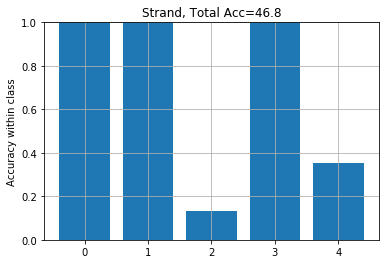

In [17]:
# Report our results
print (classification_report(y[test], yhat, digits = 3))
                
plot_class_acc(y[test], yhat, title = "Strand", class_list ='')# ', '.join(map(str, strand.classes_)))

## Test at kmer_length=31, minhash_length=200,

In [14]:
%%time
from sklearn.model_selection import StratifiedKFold

# create cross validation iterator
cv = StratifiedKFold(n_splits=5, random_state=42)

#Get only 1 stratified 80/20 split 
cvSplits = cv.split(X,y)
train, test = next(cvSplits)

# Train and test on the one fold
strand = StrandClassifierV2(kmer_length=31, minhash_length=200, random_state=42)
strand.fit(X[train],y[train])
yhat = strand.predict(X[test])

Wall time: 28.9 s


                  precision    recall  f1-score   support

    g__pelosinus      0.338     1.000     0.505        27
  g__rhodobacter      1.000     1.000     1.000         4
g__streptococcus      1.000     0.244     0.393        45
       g__vibrio      1.000     1.000     1.000         4
  g__xanthomonas      1.000     0.387     0.558        31

        accuracy                          0.523       111
       macro avg      0.868     0.726     0.691       111
    weighted avg      0.839     0.523     0.510       111



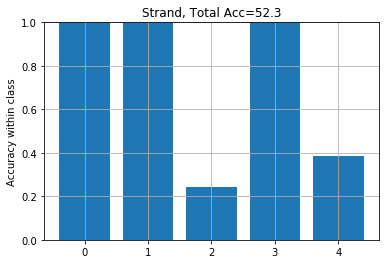

In [15]:
# Report our results
print (classification_report(y[test], yhat, digits = 3))
                
plot_class_acc(y[test], yhat, title = "Strand", class_list ='')# ', '.join(map(str, strand.classes_)))

## Test at kmer_length=31, minhash_length=300

In [16]:
%%time
from sklearn.model_selection import StratifiedKFold

# create cross validation iterator
cv = StratifiedKFold(n_splits=5, random_state=42)

#Get only 1 stratified 80/20 split 
cvSplits = cv.split(X,y)
train, test = next(cvSplits)

# Train and test on the one fold
strand = StrandClassifierV2(kmer_length=31, minhash_length=300, random_state=42)
strand.fit(X[train],y[train])
yhat = strand.predict(X[test])

Wall time: 28.5 s


                  precision    recall  f1-score   support

    g__pelosinus      0.342     1.000     0.509        27
  g__rhodobacter      1.000     1.000     1.000         4
g__streptococcus      1.000     0.267     0.421        45
       g__vibrio      1.000     1.000     1.000         4
  g__xanthomonas      1.000     0.387     0.558        31

        accuracy                          0.532       111
       macro avg      0.868     0.731     0.698       111
    weighted avg      0.840     0.532     0.523       111



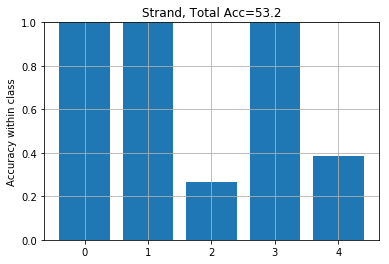

In [17]:
# Report our results
print (classification_report(y[test], yhat, digits = 3))
                
plot_class_acc(y[test], yhat, title = "Strand", class_list ='')# ', '.join(map(str, strand.classes_)))

## Test at kmer_length=31, minhash_length=400

In [19]:
%%time
from sklearn.model_selection import StratifiedKFold

# create cross validation iterator
cv = StratifiedKFold(n_splits=5, random_state=42)

#Get only 1 stratified 80/20 split 
cvSplits = cv.split(X,y)
train, test = next(cvSplits)

# Train and test on the one fold
strand = StrandClassifierV2(kmer_length=31, minhash_length=400, random_state=42)
strand.fit(X[train],y[train])
yhat = strand.predict(X[test])

Wall time: 28.5 s


                  precision    recall  f1-score   support

    g__pelosinus      0.375     1.000     0.545        27
  g__rhodobacter      1.000     1.000     1.000         4
g__streptococcus      1.000     0.378     0.548        45
       g__vibrio      1.000     1.000     1.000         4
  g__xanthomonas      1.000     0.452     0.622        31

        accuracy                          0.595       111
       macro avg      0.875     0.766     0.743       111
    weighted avg      0.848     0.595     0.601       111



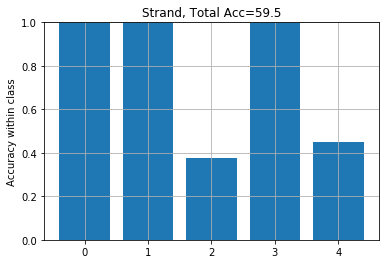

In [20]:
# Report our results
print (classification_report(y[test], yhat, digits = 3))
                
plot_class_acc(y[test], yhat, title = "Strand", class_list ='')# ', '.join(map(str, strand.classes_)))

## Test at kmer_length=31, minhash_length=500

In [21]:
%%time
from sklearn.model_selection import StratifiedKFold

# create cross validation iterator
cv = StratifiedKFold(n_splits=5, random_state=42)

#Get only 1 stratified 80/20 split 
cvSplits = cv.split(X,y)
train, test = next(cvSplits)

# Train and test on the one fold
strand = StrandClassifierV2(kmer_length=31, minhash_length=500, random_state=42)
strand.fit(X[train],y[train])
yhat = strand.predict(X[test])

Wall time: 28.2 s


                  precision    recall  f1-score   support

    g__pelosinus      0.380     1.000     0.551        27
  g__rhodobacter      1.000     1.000     1.000         4
g__streptococcus      1.000     0.400     0.571        45
       g__vibrio      1.000     1.000     1.000         4
  g__xanthomonas      1.000     0.452     0.622        31

        accuracy                          0.604       111
       macro avg      0.876     0.770     0.749       111
    weighted avg      0.849     0.604     0.612       111



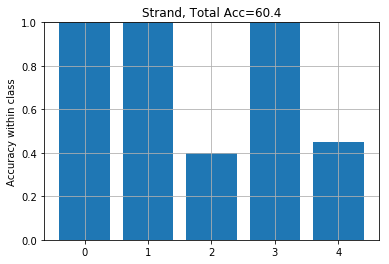

In [22]:
# Report our results
print (classification_report(y[test], yhat, digits = 3))
                
plot_class_acc(y[test], yhat, title = "Strand", class_list ='')# ', '.join(map(str, strand.classes_)))

## Test at kmer_length=31, minhash_length=1000

In [23]:
%%time
from sklearn.model_selection import StratifiedKFold

# create cross validation iterator
cv = StratifiedKFold(n_splits=5, random_state=42)

#Get only 1 stratified 80/20 split 
cvSplits = cv.split(X,y)
train, test = next(cvSplits)

# Train and test on the one fold
strand = StrandClassifierV2(kmer_length=31, minhash_length=1000, random_state=42)
strand.fit(X[train],y[train])
yhat = strand.predict(X[test])

Wall time: 28.3 s


                  precision    recall  f1-score   support

    g__pelosinus      0.458     1.000     0.628        27
  g__rhodobacter      1.000     1.000     1.000         4
g__streptococcus      1.000     0.556     0.714        45
       g__vibrio      1.000     1.000     1.000         4
  g__xanthomonas      1.000     0.613     0.760        31

        accuracy                          0.712       111
       macro avg      0.892     0.834     0.820       111
    weighted avg      0.868     0.712     0.727       111



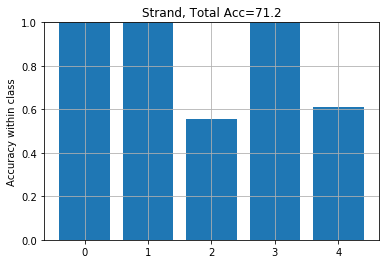

In [24]:
# Report our results
print (classification_report(y[test], yhat, digits = 3))
                
plot_class_acc(y[test], yhat, title = "Strand", class_list ='')# ', '.join(map(str, strand.classes_)))

## Test at kmer_length=31, minhash_length=2000

In [25]:
%%time
from sklearn.model_selection import StratifiedKFold

# create cross validation iterator
cv = StratifiedKFold(n_splits=5, random_state=42)

#Get only 1 stratified 80/20 split 
cvSplits = cv.split(X,y)
train, test = next(cvSplits)

# Train and test on the one fold
strand = StrandClassifierV2(kmer_length=31, minhash_length=2000, random_state=42)
strand.fit(X[train],y[train])
yhat = strand.predict(X[test])

Wall time: 29.3 s


                  precision    recall  f1-score   support

    g__pelosinus      0.529     1.000     0.692        27
  g__rhodobacter      1.000     1.000     1.000         4
g__streptococcus      1.000     0.711     0.831        45
       g__vibrio      1.000     1.000     1.000         4
  g__xanthomonas      1.000     0.645     0.784        31

        accuracy                          0.784       111
       macro avg      0.906     0.871     0.862       111
    weighted avg      0.886     0.784     0.796       111



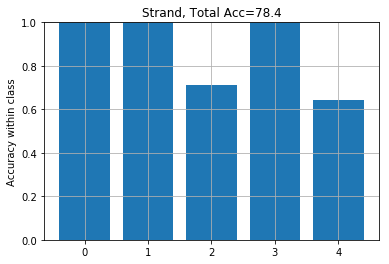

In [26]:
# Report our results
print (classification_report(y[test], yhat, digits = 3))
                
plot_class_acc(y[test], yhat, title = "Strand", class_list ='')# ', '.join(map(str, strand.classes_)))

## Test at kmer_length=31, minhash_length=4000

In [30]:
%%time
from sklearn.model_selection import StratifiedKFold

# create cross validation iterator
cv = StratifiedKFold(n_splits=5, random_state=42)

#Get only 1 stratified 80/20 split 
cvSplits = cv.split(X,y)
train, test = next(cvSplits)

# Train and test on the one fold
strand = StrandClassifierV2(kmer_length=31, minhash_length=4000, random_state=42)
strand.fit(X[train],y[train])

Wall time: 22.3 s


StrandClassifierV2(kmer_length=31, minhash_length=4000, random_state=42)

                  precision    recall  f1-score   support

    g__pelosinus      0.529     1.000     0.692        27
  g__rhodobacter      1.000     1.000     1.000         4
g__streptococcus      1.000     0.711     0.831        45
       g__vibrio      1.000     1.000     1.000         4
  g__xanthomonas      1.000     0.645     0.784        31

        accuracy                          0.784       111
       macro avg      0.906     0.871     0.862       111
    weighted avg      0.886     0.784     0.796       111



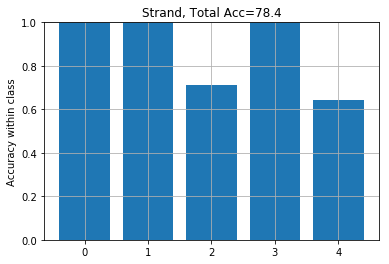

In [32]:
# Report our results
print (classification_report(y[test], yhat, digits = 3))
                
plot_class_acc(y[test], yhat, title = "Strand", class_list ='')# ', '.join(map(str, strand.classes_)))

## Test at kmer_length=60, minhash_length=100,

In [18]:
%%time
from sklearn.model_selection import StratifiedKFold

# create cross validation iterator
cv = StratifiedKFold(n_splits=5, random_state=42)

#Get only 1 stratified 80/20 split 
cvSplits = cv.split(X,y)
train, test = next(cvSplits)

# Train and test on the one fold
strand = StrandClassifierV2(kmer_length=60, minhash_length=100, random_state=42)
strand.fit(X[train],y[train])
yhat = strand.predict(X[test])

Wall time: 29.2 s


                  precision    recall  f1-score   support

    g__pelosinus      0.287     1.000     0.446        27
  g__rhodobacter      1.000     1.000     1.000         4
g__streptococcus      1.000     0.022     0.043        45
       g__vibrio      1.000     1.000     1.000         4
  g__xanthomonas      1.000     0.258     0.410        31

        accuracy                          0.396       111
       macro avg      0.857     0.656     0.580       111
    weighted avg      0.827     0.396     0.313       111



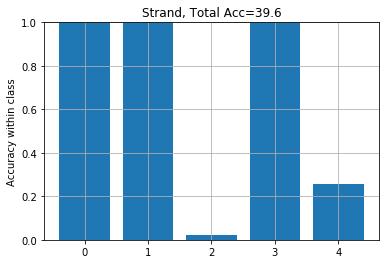

In [19]:
# Report our results
print (classification_report(y[test], yhat, digits = 3))
                
plot_class_acc(y[test], yhat, title = "Strand", class_list ='')# ', '.join(map(str, strand.classes_)))

## Parallel 10-Fold CV at kmer_length=31, minhash_length=2000,

In [33]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=42)

# Create our Strand sequence classifier
strand = StrandClassifierV2(kmer_length=31, minhash_length=2000, random_state=42)

#run in parallel on all available cores
yhat = cross_val_predict(strand, X, y, cv=cv, n_jobs=-1)

Wall time: 1min 36s


                  precision    recall  f1-score   support

    g__pelosinus      0.630     0.978     0.766       134
  g__rhodobacter      1.000     0.944     0.971        18
g__streptococcus      0.990     0.919     0.953       221
       g__vibrio      0.941     0.941     0.941        17
  g__xanthomonas      1.000     0.623     0.767       151

        accuracy                          0.852       541
       macro avg      0.912     0.881     0.880       541
    weighted avg      0.902     0.852     0.855       541



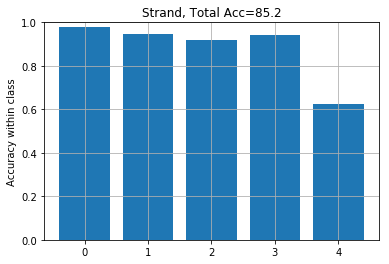

In [34]:
# Report our results
print (classification_report(y, yhat, digits = 3))
                
plot_class_acc(y, yhat, title = "Strand", class_list = '')